<a><img style="float: right;" src="https://i.ibb.co/1qVSNwH/FP.png" alt="FP" border="0"></a>

In [2]:
%matplotlib inline

# importing libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

pd.options.display.float_format = '{:,.5f}'.format

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

# Defining today's Date
from datetime import date
today = date.today()

#### Functions ####
def compute_growth_rate(dataframe, initial_value=100, initial_cost=0, ending_cost=0):
    initial_cost = initial_cost / 100
    ending_cost  = ending_cost / 100
    
    GR = ((1 + dataframe.pct_change()).cumprod()) * (initial_value * (1 - initial_cost))
    GR.iloc[0]  = initial_value * (1 - initial_cost)
    GR.iloc[-1] = GR.iloc[-1] * (1 * (1 - ending_cost))
    return GR 

def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100

def compute_return(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0, investment_value=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
    
    if investment_value == 0:
        return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)
    else:
        return (dataframe.iloc[-1].div(investment_value).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe, investment_value=0):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    if investment_value == 0:
        return(dataframe.iloc[-1] / dataframe.iloc[0] -1) * 100
    else:
        return(dataframe.iloc[-1] / investment_value -1) * 100

def compute_performance_table(dataframe, years='si', freq='days', investment_value=0):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['Return', 'CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df
    
    else:
        df = pd.DataFrame([compute_return(dataframe, investment_value), compute_cagr(dataframe, years, investment_value), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day < 0:
        day = - day
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years ' + str(month) + ' Months ' + str(day) + ' Days')

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = dataframe.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
def get(quotes):

    # resample quotes to business month
    monthly_quotes = quotes.resample('BM').last()
    
    # get monthly returns
    returns = monthly_quotes.pct_change()

    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plot(returns,
         title="Monthly Returns (%)",
         title_color="black",
         title_size=12,
         annot_size=10,
         figsize=None,
         cmap='RdYlGn',
         cbar=False,
         square=False):

    returns = get(returns)
    returns *= 100
    
    if figsize is None:
        size = list(plt.gcf().get_size_inches()) 
        figsize = (size[0], size[0] // 2)
        plt.close()

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(returns, ax=ax, annot=True,
                     annot_kws={"size": annot_size}, fmt="0.2f", linewidths=0.4, center=0,
                     square=square, cbar=cbar, cmap=cmap)
    ax.set_title(title, fontsize=title_size, color=title_color, fontweight="bold")

    fig.subplots_adjust(hspace=0)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()


PandasObject.get_returns_heatmap = get
PandasObject.plot_returns_heatmap = plot

def calendarize(returns):
    
    '''
    The calendarize function is an slight adaption of ranaroussi's monthly-returns-heatmap 
    You can find it here: https://github.com/ranaroussi/monthly-returns-heatmap/
    
    It turns monthly data into a 12 columns(months) and yearly row seaborn heatmap
    '''
    
    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plotly_table(df, width=990, height=500, columnwidth=[25], title=None , index=True, header=True,
                 header_alignment=['center'],  header_line_color='rgb(100, 100, 100)', header_font_size=[12],
                 header_font_color=['rgb(45, 45, 45)'], header_fill_color=['rgb(200, 200, 200)'],
                 cells_alignment=['center'], cells_line_color=['rgb(200, 200, 200)'], cells_font_size=[11], 
                 cells_font_color=['rgb(45, 45, 45)'], cells_fill_color=['rgb(245, 245, 245)','white' ]):
    
    # Making the header bold and conditional  
        if (header == False and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header.pop(0)
            header =  [[]] + header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
              
        # Making the header bold and conditional  
        if (header == True and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [['']] + header
            
            # Making the index Bold
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == False and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [[]] + header
            
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == True and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
        
        if title == None:
            layout = go.Layout(
                autosize=False,
                height=height,
                width=width,
                margin=dict (l=0, r=0, b=0, t=0, pad=0),
            )
        else:
                layout = go.Layout(
                    autosize=False,
                    height=height,
                    width=width,
                    title=title,
                    margin=dict( l=0, r=0, b=0, t=25, pad=0),
                )

        data = [trace]
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, show_link=False, config={'modeBarButtonsToRemove': ['sendDataToCloud','hoverCompareCartesian'],
                                               'displayModeBar': False})

def compute_portfolio(quotes, weights):
    
    # Anos do Portfolio
    Years = quotes.index.year.unique()

    # Dicionário com Dataframes anuais das cotações dos quotes
    Years_dict = {}
    k = 0

    for Year in Years:
        # Dynamically create key
        key = Year
        # Calculate value
        value = quotes.loc[str(Year)]
        # Insert in dictionary
        Years_dict[key] = value
        # Counter
        k += 1

    # Dicionário com Dataframes anuais das cotações dos quotes
    Quotes_dict = {}
    Portfolio_dict = {}

    k = 0    
    
    for Year in Years:
        
        n = 0
        
        #Setting Portfolio to be a Global Variable
        global Portfolio
        
        # Dynamically create key
        key = Year

        # Calculate value
        if (Year-1) in Years:
            value = Years_dict[Year].append(Years_dict[Year-1].iloc[[-1]]).sort_index()
        else:
            value = Years_dict[Year].append(Years_dict[Year].iloc[[-1]]).sort_index()

        # Set beginning value to 100
        value = (value / value.iloc[0]) * 100
        # 
        for column in value.columns:
            value[column] = value[column] * weights[n]
            n +=1
        
        # Get Returns
        Returns = value.pct_change()
        # Calculating Portfolio Value
        value['Portfolio'] = value.sum(axis=1)

        # Creating Weights_EOP empty DataFrame
        Weights_EOP = pd.DataFrame()
        # Calculating End Of Period weights
        for Name in Nomes:
            Weights_EOP[Name] = value[Name] / value['Portfolio']
        # Calculating Beginning Of Period weights
        Weights_BOP = Weights_EOP.shift(periods=1)

        # Calculatins Portfolio Value
        Portfolio = pd.DataFrame(Weights_BOP.multiply(Returns).sum(axis=1))
        Portfolio.columns=['Simple']
        # Transformar os simple returns em log returns 
        Portfolio['Log'] = np.log(Portfolio['Simple'] + 1)
        # Cumsum() dos log returns para obter o preço do Portfolio 
        Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        Portfolio['Price'] = Portfolio['Price']   

        # Insert in dictionaries
        Quotes_dict[key] = value
        Portfolio_dict[key] = Portfolio
        # Counter
        k += 1

    # Making an empty Dataframe for Portfolio data
    Portfolio = pd.DataFrame()

    for Year in Years:
        Portfolio = pd.concat([Portfolio, Portfolio_dict[Year]['Log']])

    # Delete repeated index values in Portfolio    
    Portfolio.drop_duplicates(keep='last')

    # Naming the column of log returns 'Log'
    Portfolio.columns= ['Log']

    # Cumsum() dos log returns para obter o preço do Portfolio 
    Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        
    # Round Portfolio to 2 decimals and eliminate returns
    Portfolio = pd.DataFrame(round(Portfolio['Price'], 2))

    # Naming the column of Portfolio as 'Portfolio'
    Portfolio.columns= ['Portfolio']

    # Delete repeated days
    Portfolio = Portfolio.loc[~Portfolio.index.duplicated(keep='first')]

    return Portfolio
    
# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1, days=252):
    shifted = df.shift(days * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

def compute_drawdowns_i(dataframe):
    '''
    Function to compute drawdowns based on 
    the inicial value of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / 100 -1) * 100
        
def print_title(string):
    display(Markdown('**' + string + '**'))
    
def all_percent(df):
    for column in df.columns:
        df[column] = df[column].apply( lambda x : str(x) + '%')
        return df

def preview(df):
    return pd.concat([df.head(3), df.tail(3)])

dimensions=(990, 500)

colorz = ['royalblue', 'orange', 'dimgrey', 'darkorchid']

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### print color.BOLD + 'Hello World !' + color.END

##################################################
### Begin of compute_drawdowns_table function ####
##################################################

### Função auxiliar 1
def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day == 0:
        day = - day
        
    if day < 0:
        month =  month - 1
        if timestamp_1.month not in [1, 3, 5, 7, 8, 10, 12]:
            day = 31 + day
        else:
            day = 30 + day        
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years, ' + str(month) + ' Months, ' + str(day) + ' Days')

### Função auxiliar 2
def compute_drawdowns_periods(df):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdown_periods = list()

    for i in range(0, len(df.index)):
      
        drawdown_periods.append(compute_time_period(df.index[i], df.index[i - 1]))
    
    drawdown_periods = pd.DataFrame(drawdown_periods)
    
    return (drawdown_periods)


### Função auxiliar 3
def compute_max_drawdown_in_period(prices, timestamp_1, timestamp_2):
    
    df = prices[timestamp_1:timestamp_2]
    
    max_dd = compute_max_DD(df)
    
    return max_dd

### Função auxiliar 4
def compute_drawdowns_min(df, prices):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdowns_min = list()

    for i in range(0, len(df.index) - 1):
      
        drawdowns_min.append(compute_max_drawdown_in_period(prices, df.index[i], df.index[i + 1]))
    
    drawdowns_min = pd.DataFrame(drawdowns_min)
    
    return(drawdowns_min)

### Função principal
def compute_drawdowns_table(prices, number=5):

    # input: df of prices
    dd = compute_drawdowns(prices)
    
    max_points = dd[dd == 0].dropna()
        
    data = [0.0] 
  
    # Create the pandas DataFrame
    new_data = pd.DataFrame(data, columns = ['New_data'])

    new_data['Date'] = prices.index.max()

    new_data.set_index('Date', inplace=True)

    max_points = pd.DataFrame(pd.concat([max_points, new_data], axis=1).iloc[:, 0])
    
    dp = compute_drawdowns_periods(max_points)
        
    dp.set_index(max_points.index, inplace=True)
    
    df = pd.concat([max_points, dp], axis=1)
    
    df.index.name = 'Date'
    
    df.reset_index(inplace=True)
    
    df['End'] = df['Date'].shift(-1)
    
    df[0] = df[0].shift(-1)
    
    df['values'] = round(compute_drawdowns_min(max_points, prices), 2)
    
    df = df.sort_values(by='values')
    
    df['Number'] = range(1, len(df) + 1)
    
    df.reset_index(inplace=True)
    
    df.columns = [['index', 'Begin', 'point', 'Length', 'End', 'Depth', 'Number']]
    
    df = df[['Begin', 'End', 'Depth', 'Length']].head(number)
    
    df.iloc[:, 2] = df.iloc[:, 2].apply( lambda x : str(x) + '%')
    
    df.set_index(np.arange(1, number + 1), inplace=True)
               
    for index, row in df['End'].iterrows():
        
        if ( (row[0] == prices.index.max())):# & (prices.iloc[-1][0] < prices.max()) ):
            
            df.iloc[index-1, 1] = float('NaN')

    return(df)

################################################
### End of compute_drawdowns_table function ####
################################################

def compute_r2(x, y, k=1):
    xpoly = np.column_stack([x**i for i in range(k+1)])    
    return sm.OLS(y, xpoly).fit().rsquared

def compute_r2_table(df, benchmark):

# df of prices

    lista = []

    for i in np.arange(0, len(df.columns)):
        lista.append(compute_r2(benchmark, df.iloc[: , i]))
             
    Dataframe = pd.DataFrame(lista)
    
    Dataframe.index = df.columns
    
    Dataframe.columns = [benchmark.name]
    
    return(round(Dataframe.transpose(), 3))

colors = ['royalblue',            # 1 - royalblue
          'dimgrey',              # 2 - dimgrey
          'rgb(255, 153, 51)',    # 3 - orange
          'indigo',               # 4 - Indigo
          'rgb(219, 64, 82)',     # 5 - Red
          'rgb(0, 128, 128)',     # 6 - Teal
          '#191970',              # 7 - Navy
          'rgb(128, 128, 0)',     # 8 - Olive
          '#00BFFF',              # 9 - Water Blue
          'rgb(128, 177, 211)']   # 10 - Blueish

In [3]:
# Downloading funds and creating quotes and returns dataframes

# End = '2017-08-20' # Só activas se quiseres que acabe num dia especifíco 

ISINs = ['IE00BGCZ0933', 'SC0J', 'IQQ0']
Nomes = ['VG_GB'      , 'SC0J' , 'IQQ0']

fundos = pd.read_csv('Cotacoes_diarias.csv', index_col = 'Date', parse_dates = True)[ISINs]

fundos.columns = Nomes
fundos = fundos.dropna()

In [4]:
#### Normalization to 100 ####
fundos = round((fundos / fundos.iloc[0] * 100), 2)

INFO: NumExpr defaulting to 4 threads.

# Comparação entre SC0J/SMSWLD e IQQ0/MVOL

- [Invesco MSCI World UCITS ETF (EUR) | SC0J - IE00B60SX394 ](https://etf.invesco.com/pt/institutional/en/product/invesco-msci-world-ucits-etf-acc/trading-information) - ETF tracker do MSCI World - [ETF no Banco Invest](https://www.bancoinvest.pt/poupanca-e-investimento/titulos/etf/detalhe?simbolo=SMSWLD%20GY&tipotitulo=ETF)
- [iShares Edge MSCI World Minimum Volatility UCITS ETF USD (Acc) (EUR) | IQQ0](http://www.morningstar.es/es/etf/snapshot/snapshot.aspx?id=0P0000Y2A1) - ETF tracker do MSCI World Minimum Volatility- [ETF no Banco Invest](https://www.bancoinvest.pt/poupanca-e-investimento/titulos/etf/detalhe?simbolo=IQQ0%20GY&tipotitulo=ETF)

Segundo o <a href="https://www.blackrock.com/lu/intermediaries/literature/kiid/kiid-ishares-edge-msci-world-minimum-volatility-ucits-etf-usd-acc-gb-ie00b8fhgs14-en.pdf" target="_blank">KIID do iShares minimum volatility</a>:

*The benchmark index aims to reflect the performance characteristics of a subset of securities within the MSCI World Index (“Parent Index”) with the lowest absolute volatility of returns, subject to risk diversification. The constituents of the benchmark index are selected using a minimum volatility strategy which selects securities from the Parent Index based on estimates of the risk profile and expected volatility of each constituent and the correlation between all constituents in the Parent Index. Volatility of returns measures the movements in the daily price of the constituents over a period of time.*

A ideia do minimum volatility tem por base o uso de <a href="https://www.investopedia.com/terms/s/smart-beta.asp" target="_blank">Smart Beta</a>, neste caso uma ["anomalia"](https://en.wikipedia.org/wiki/Low-volatility_anomaly) bastante estudada quer nos <a href="https://tinyurl.com/y6anpgsd" target="_blank">serviços financeiros</a> quer em <a href="https://etf.dws.com/en-LU/EmeaAssetDownload/Index/8f1c0395-57ac-4a22-819b-94328e6b108f/Passive-Insights-1-Smart-Beta-Building-Low-Volatility-Portfolios-of-ETFs.pdf" target="_blank">termos académicos</a> que as acções com baixa volatilidade não demonstram ter, necessariamente, retornos inferiores ao resto do mercado.

Nem tudo é necessariamente cor-de-rosa e devemos também ter uma visão crítica, onde muitas vezes somos relembrados que **"Rentabilidade passada não é garantia de rentabilidade futura"**. Neste artigo do públicado no blog do CFA institute denominado <a href="https://blogs.cfainstitute.org/investor/2018/10/29/the-dark-side-of-low-volatility-stocks/" target="_blank">The Dark Side of Low-Volatility Stocks</a> o autor tem como conclusão *"Declining interest rates likely explain most of the low-volatility strategy’s attractive risk-adjusted returns [...] Low-volatility stocks were great for risk reduction over the last few decades, protecting capital during equity market downturns. But the long US bond bull market may have run its course, and if bond and equity markets correct simultaneously, low-volatility stocks may not provide so safe a haven."*

Nos últimos anos têm de facto aparecido uma grande quantidade de ETFs dedicado a Smart Beta/Factor Investing. Dado que esses ETFs começam a ter alguns anos de comercialização temos já dados concretos da sua performance, ao invés de backtests teóricos.

Abaixo podemos ver a comparação directa entre um ETF que segue o MSCI World "normal" e outro o MSCI World Minimum Volatility. A análise começa desde o início de comercialização do IQQ0 a 2013-02-12. Esta comparação corrobora que o Minimum Volatility teve, de facto, algumas vantagens em termos históricos, nomeadamente drawdowns mais baixos, sendo isso mais evidente em períodos de maior queda, como o final de 2018.

Como seria de esperar em períodos de subida a performance do SC0J é superior, mas teve normalmente que recuperar de uma base inferior devido à sua maior queda. Embora neste momento o IQQ0 esteja com overperformance absoluta nada nos faz pensar que assim vai continuar. Já em 2016 tinha apresentado uma grande overperformance que acabou por ser corrigida/compensada entre a segunda metade de 2016 e a primeira metade de 2017.

In [5]:
Begin = fundos.head(1).index
Begin = str(Begin.strftime('%Y-%m-%d'))[8:18]

**Dica:** A interactividade dos gráficos da plotly permite:

    . Zoom (mantenham o clique e arrastem o cursor em simultâneo, em cima do gráfico);
    . Tem uma lista de opções que aparece se forem com o cursor ao canto superior direito;
    . Façam duplo clique no gráfico ou seleccionem a opção Autoscale/Reset Axes para voltar ao normal;
    . Alterem a opção de 'Compare data on hoover' para 'Show closest data on hoover' se vos for mais conveniente;
    . Se clicarem num nome na legenda esse fundo desaparece (clicando de novo ele volta a apetecer).

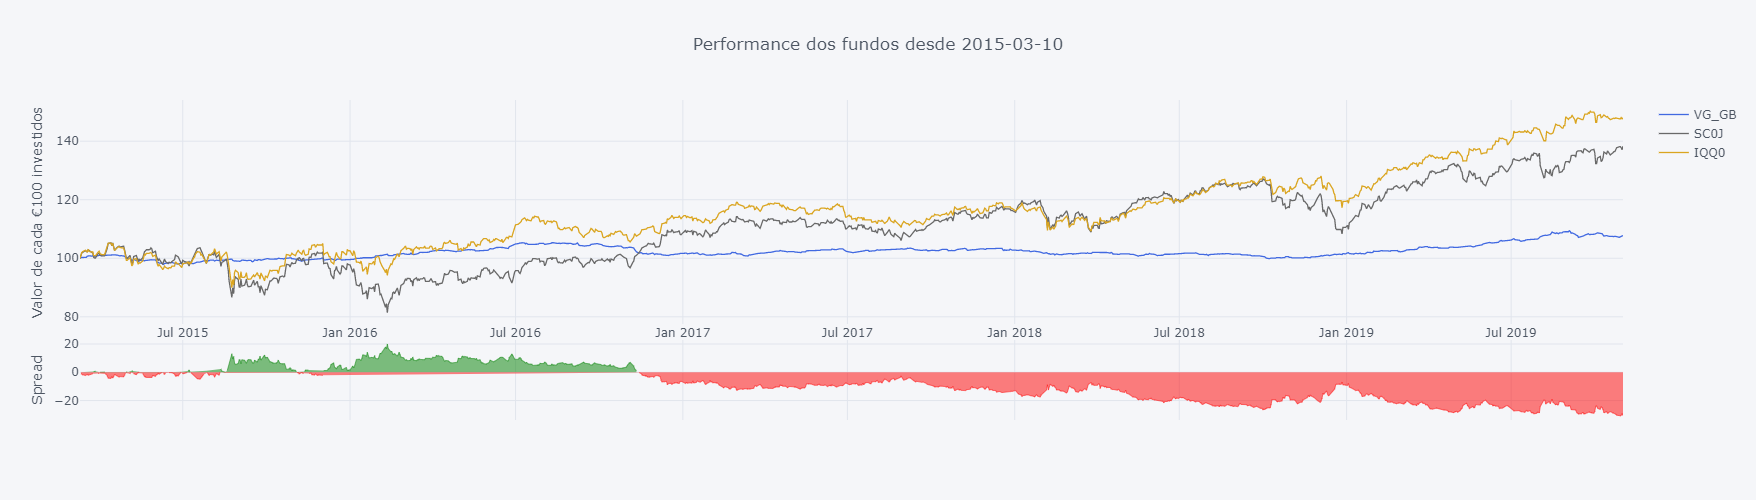

In [47]:
# Making Color Palette
Palette = ['rgb(255, 153, 51)',     # 1 - orange
            'royalblue',            # 2 - Royalblue
            '#708090',              # 3 - Grey
            'rgb(128, 0, 128)',     # 4 - Indigo
            'rgb(219, 64, 82)',     # 5 - Red
            'rgb(0, 128, 128)',     # 6 - Teal
            '#191970',              # 7 - Navy
            'rgb(128, 128, 0)',     # 8 - Olive
            '#00BFFF',              # 9 - Water Blue
            'rgb(128, 177, 211)']   # 10 - 

fundos.iplot(title='Performance dos fundos desde ' + Begin, yTitle='Valor de cada €100 investidos', color=['royalblue', 'dimgrey', 'goldenrod'], kind='spread', dimensions=dimensions)

O gráfico acima apresenta a linha de performance de ambos os ETFs. Em baixo podemos ver um pequeno gráfico do diferencial absoluto entre ambos e nos apercebermos facilmente das diferentes performances ao longo do tempo. Podemos observar uma overperformance do IQQ0 em períodos de stress dos mercados accionistas que acaba por ser compensada por uma underperformance quando os mercados estão a subir.

In [7]:
print_title('Valores finais dos fundos tendo começado em ' + Begin + ' com 100 euros')
fundos.tail(1)

**Valores finais dos fundos tendo começado em 2015-03-10 com 100 euros**

,VG_GB,SC0J,IQQ0
Date,,,
2019-11-01,107.76000,138.29000,147.98000


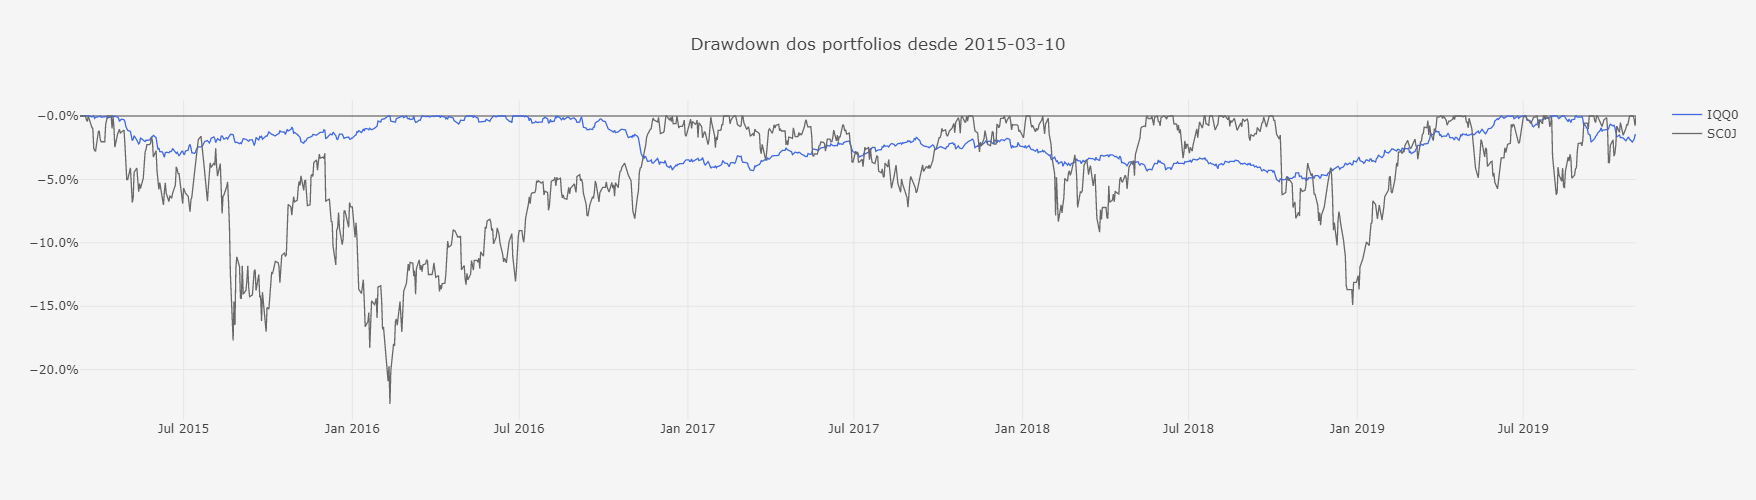

In [39]:
DD = compute_drawdowns(fundos)
DD = DD /100

layout = go.Layout(
    title='Drawdown dos portfolios desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    width=990,
    height=500,
    xaxis=dict(
        title='',
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(
        title='',
        showgrid=True,
        zeroline=True, # Adicionar ou não a zero line
        tickformat=".1%", # tickformat=".2%" se quiseres mais casas decimais
    ))

trace0 = go.Scatter(
    x = DD.index,
    y = DD.iloc[:, 0],
    name = 'IQQ0',
    line = dict(
        color = 'royalblue',
        width = 1.3)
)

trace1 = go.Scatter(
    x = DD.index,
    y = DD.iloc[:, 1],
    name = 'SC0J',
    line = dict(
        color = 'dimgrey',
        width = 1.3)
)

data = [trace0, trace1]
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [9]:
print_title('Drawdown actual (' + str(today) + ')')
DD = compute_drawdowns(fundos)
DD = DD /100
round(DD.tail(1), 5).applymap(lambda x: "{0:.2f}%".format(x*100))

**Drawdown actual (2019-11-03)**

,VG_GB,SC0J,IQQ0
Date,,,
2019-11-01,-1.49%,0.00%,-1.50%


No gráfico acima podemos visualizar os drawdowns de ambos os ETFs. Reparamos que para drawdowns pequenos (abaixo de 10%) as quedas são semelhantes, mas em momentos extremos em que os drawdowns chegam aos dois dígitos é onde o IQQ0 demonstra as suas vantagens. Podemos ver isso na quebra do início de 2016 onde o SC0J teve uma quebra de 22.5% face aos máximos enquanto o IQQ0 apenas 10.5%. Isso repete-se de forma muito semelhante na queda do último trimestre de 2018.

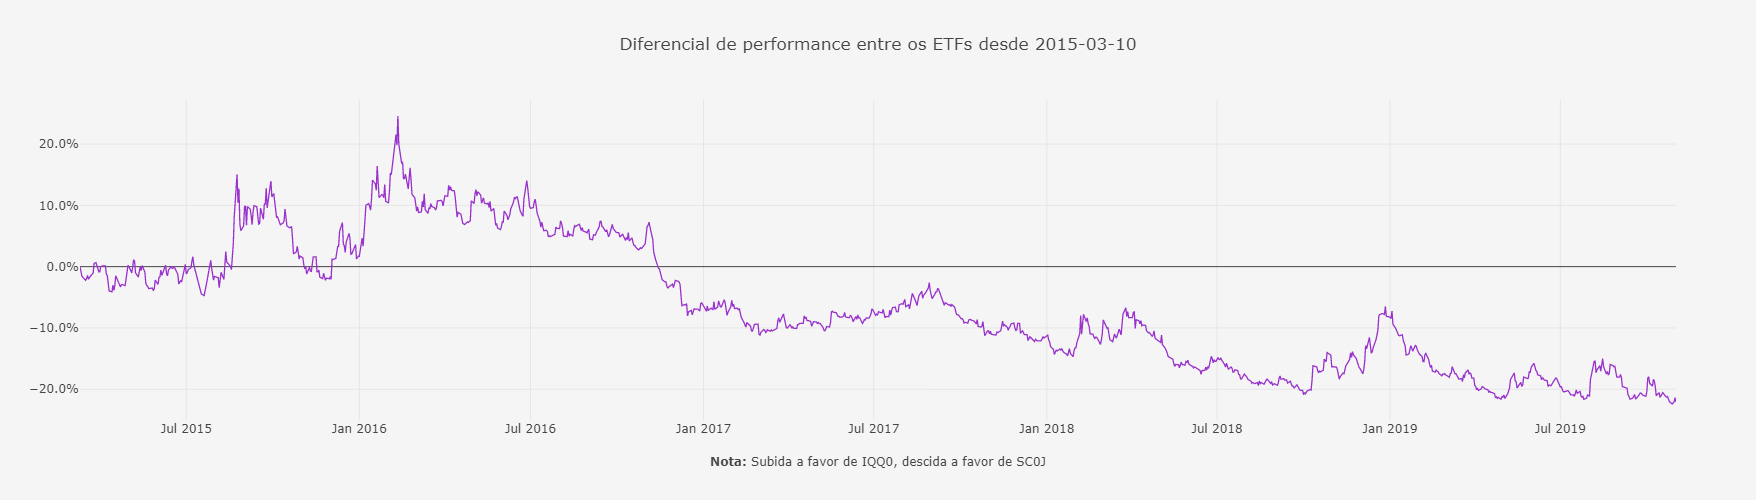

In [10]:
layout = go.Layout(
    title='Diferencial de performance entre os ETFs desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    width=990,
    height=500,
    xaxis=dict(
        title='<b>Nota:</b> Subida a favor de IQQ0, descida a favor de SC0J',
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(
        title='',
        showgrid=True,
        zeroline=True, # Adicionar ou não a zero line
        tickformat=".1%" # tickformat=".2%" se quiseres mais casas decimais
    ))

trace0 = go.Scatter(
    x = fundos.index,
    y = (round(((fundos.iloc[:, 0]/fundos.iloc[:, 1])- 1), 5)),
    name = 'Portfolio',
    line = dict(
        color = 'darkorchid',
        width = 1.3)
)

data = [trace0]
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Este gráfico apresenta a diferença relativa (ao invés da absoluta) entre ambos os ETFs. Como já vimos acima a maior diferença entre os ETFs aconteceu no início de 2016, devido a uma grande diferença na dimensão do drawdown. Isso foi normalizado entre meados de 2016 e início de 2018.

In [11]:
print_title('Performance dos fundos desde ' + Begin)
compute_performance_table(fundos)

**Performance dos fundos desde 2015-03-10**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
VG_GB,7.76%,1.62%,2.51%,0.64000,-5.18%,0.31000
SC0J,38.29%,7.22%,14.91%,0.48000,-22.71%,0.32000
IQQ0,47.98%,8.79%,12.23%,0.72000,-14.52%,0.61000


In [12]:
print_title('Performance a 12 meses')
fundos_1 = filter_by_date(fundos, years=1)
compute_performance_table(fundos_1)

**Performance a 12 meses**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
VG_GB,7.42%,7.40%,2.66%,2.78000,-2.07%,3.58000
SC0J,15.39%,15.34%,13.09%,1.17000,-11.61%,1.32000
IQQ0,19.52%,19.46%,10.05%,1.94000,-8.47%,2.30000


Este diferencial de performance a 12 meses deve-se principalmente à menor quebra do IQQ0 no final de 2018.

In [13]:
print_title('Performance a 3 anos')
fundos_3 = filter_by_date(fundos, years=3)
compute_performance_table(fundos_3)

**Performance a 3 anos**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
VG_GB,4.09%,1.34%,2.44%,0.55000,-3.77%,0.36000
SC0J,40.45%,11.98%,11.87%,1.01000,-14.90%,0.80000
IQQ0,38.60%,11.48%,9.59%,1.20000,-8.47%,1.36000


In [14]:
print_title('Performance a 5 anos')
fundos_5 = filter_by_date(fundos, years=5)
compute_performance_table(fundos_5)

**Performance a 5 anos**

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
VG_GB,7.76%,1.62%,2.51%,0.64000,-5.18%,0.31000
SC0J,38.29%,7.22%,14.91%,0.48000,-22.71%,0.32000
IQQ0,47.98%,8.79%,12.23%,0.72000,-14.52%,0.61000


- **CAGR:** Retorno geométrico anualizado do portfolio;
- **StdDev:** Desvio padrão anualizado do portfolio (quanto mais alto mais risco tem a carteira);
- **Sharpe:** CAGR/StdDev (quanto mais alto melhor);
- **Max DD:** Maior queda do portfolio;
- **MAR:** CAGR/Max DD (quanto mais alto melhor).

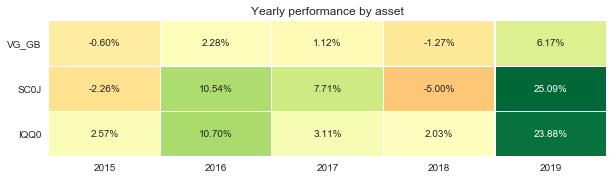

In [15]:
fundos_norm = fundos.copy()

# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([yearly_quotes_fundos.iloc[:1], yearly_quotes_fundos])
yearly_quotes_fundos = pd.concat([pd.DataFrame(fundos_norm.iloc[0]).transpose(), yearly_quotes_fundos.iloc[1:]])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Calcular em valores percentuais
yearly_returns_fundos = yearly_returns_fundos / 100

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(10,2.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0.02, fmt='.2%')
plt.yticks(rotation=360)
plt.title('Yearly performance by asset')
plt.show()

In [16]:
print_title('Drawdown Table de ' + fundos.iloc[:, 0].name)
compute_drawdowns_table(fundos.iloc[:, 0])

**Drawdown Table de VG_GB**

,Begin,End,Depth,Length
1,2016-08-10,2019-06-07,-5.18%,"2 Years, 9 Months, 28 Days"
2,2015-04-15,2016-02-08,-3.25%,"0 Years, 9 Months, 24 Days"
3,2019-09-03,NaT,-2.07%,"0 Years, 1 Months, 29 Days"
4,2019-07-04,2019-07-31,-0.85%,"0 Years, 0 Months, 27 Days"
5,2016-04-07,2016-05-05,-0.63%,"0 Years, 0 Months, 28 Days"


In [17]:
print_title('Drawdown Table de ' + fundos.iloc[:, 1].name)
compute_drawdowns_table(pd.DataFrame(fundos.iloc[:, 1]))

**Drawdown Table de SC0J**

,Begin,End,Depth,Length
1,2015-04-13,2016-12-08,-22.71%,"1 Years, 7 Months, 25 Days"
2,2018-10-01,2019-04-01,-14.9%,"0 Years, 6 Months, 0 Days"
3,2018-01-23,2018-05-17,-9.16%,"0 Years, 3 Months, 24 Days"
4,2017-03-01,2017-10-27,-7.19%,"0 Years, 7 Months, 26 Days"
5,2019-07-26,2019-09-11,-6.21%,"0 Years, 1 Months, 16 Days"


Outra grande diferença entre o IQQ0 e o MSCI World também pode ser vista aqui. Enquanto o SC0J apenas teve um drawdown de grande extensão (neste caso 1 ano e 7 meses) o SC0J apresenta dois drawdowns de alguma extensão, um de um ano e outro de 1 ano e 2 meses. Ou seja, embora historicamente menos profundos o IQQ0 não é estranho a drawdowns com períodos superiores a um ano. Chamo a atenção para o facto de ele ter feito um máximo em 4 de Dezembro de 2018 (e ter começado aí o drawdown de fim de 2018) ao contrário do SC0J que começou em 2018-10-03.

In [18]:
# Turning daily quotes into monthly
Portfolio_M = fundos.resample('BM').last()
# Monthly returns
Portfolio_ret_M = Portfolio_M.pct_change()

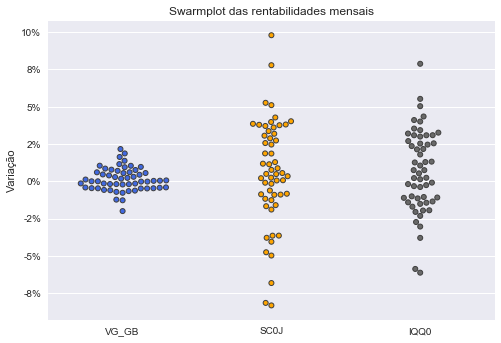

In [19]:
my_pal = ["royalblue", "orange", "dimgrey"]

ax = sns.swarmplot(data=Portfolio_ret_M, orient='v', linewidth=1,  palette=my_pal)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title("Swarmplot das rentabilidades mensais")
ax.set_xlabel('')
ax.set_ylabel('Variação')
plt.show()

Este gráfico apresenta um ponto por cada rentabilidade mensal. Podemos ver o quanto os valores negativos extremos são inferiores no IQQ0, com as duas piores rentabilidades a rondar os -6%, enquanto no SC0J ultrapassam os -8%. Podemos ver no quadro abaixo em que meses isso aconteceu.

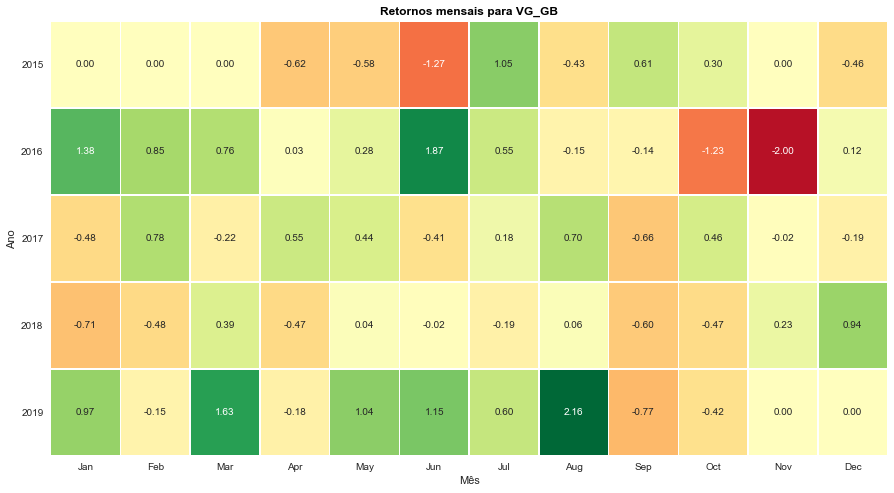

In [20]:
# Compute monthly returns table
nr = 0

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, 8))

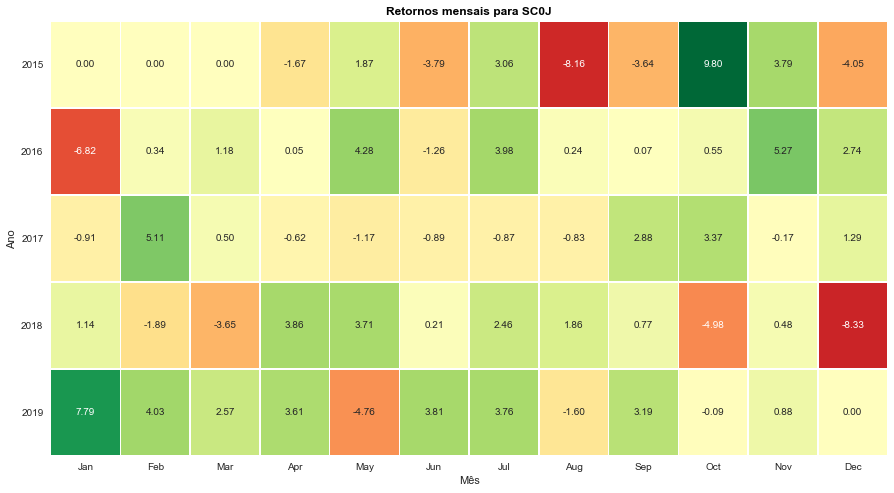

In [21]:
# Compute monthly returns table
nr = 1

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, 8))

In [22]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [23]:
import ipywidgets as widgets
from IPython.display import display

In [24]:
fundos.head()

,VG_GB,SC0J,IQQ0
Date,,,
2015-03-10,100.00000,100.00000,100.00000
2015-03-11,100.26000,101.27000,101.22000
2015-03-12,100.29000,101.85000,101.96000
2015-03-13,100.25000,102.02000,102.28000
2015-03-16,100.33000,102.62000,102.73000


In [25]:
portfolio = compute_portfolio(fundos, [0.3, 0.4, 0.3])

In [58]:
def compute_growth_rate(VG_GB=0.33, SC0J=0.34, IQQ0=0.33, ytop=141):       
    pesos = list([VG_GB, SC0J, IQQ0])
    portfolio = compute_portfolio(fundos, pesos)
    
    layout = go.Layout(
    title='Drawdown dos portfolios desde ' + Begin,
    plot_bgcolor='#f5f5f5',
    paper_bgcolor='#f5f5f5',
    width=990,
    height=500,
    xaxis=dict(
        title='',
        showgrid=True,
        titlefont=dict(size=12),
    ),
    yaxis=dict(range=[85, ytop])
    )
    
    portfolio.iplot(dimensions=dimensions, colors=colors, layout=layout)
    DD = compute_drawdowns(portfolio)
    DD = DD /100
    DD.iplot(dimensions=dimensions, colors='darkorange')
    print(compute_performance_table(portfolio))

In [59]:
from IPython.core.display import HTML
display(HTML(compute_performance_table(portfolio).to_html()))

,Return,CAGR,StdDev,Sharpe,Max DD,MAR
Portfolio,31.52%,6.07%,9.30%,0.65000,-12.34%,0.49000


In [60]:
peso_1 = 0.4

list([peso_1, 1-peso_1])

[0.4, 0.6]

In [73]:
a = widgets.interactive(compute_growth_rate, 
                    VG_GB=(0, 1, .05), 
                    SC0J=(0, 1, .05),
                    IQQ0=(0, 1, .05),
                    ytop=(86, 152, 5),
                   )

In [74]:
display(a)

interactive(children=(FloatSlider(value=0.33, description='VG_GB', max=1.0, step=0.05), FloatSlider(value=0.34…